In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("deadskull7/fer2013")

print("Path to dataset files:", fer2013.csv)

(35887, 3)
Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64
emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64


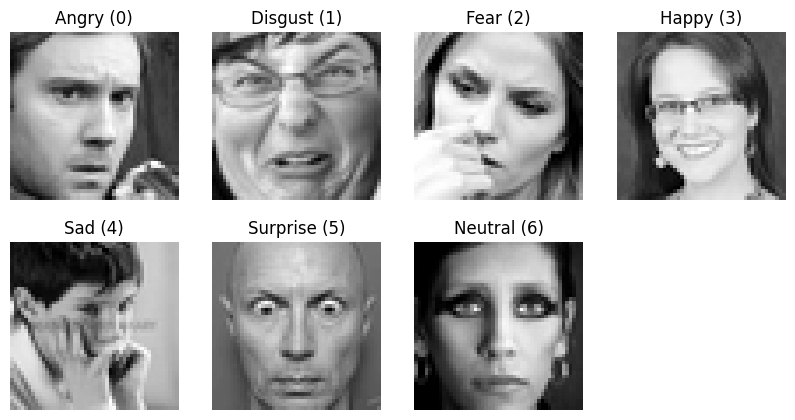

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('fer2013.csv')   # path to your CSV
print(df.shape)
print(df.Usage.value_counts())
print(df.emotion.value_counts())

# helper to convert pixel string -> 48x48 array
def pixels_to_array(s):
    arr = np.fromstring(s, dtype=np.uint8, sep=' ')
    return arr.reshape(48,48)

# show sample one per class
emotion_map = {0:"Angry",1:"Disgust",2:"Fear",3:"Happy",4:"Sad",5:"Surprise",6:"Neutral"}
plt.figure(figsize=(10,5))
for i in range(7):
    idx = df.index[df.emotion == i][0]
    img = pixels_to_array(df.loc[idx, 'pixels'])
    plt.subplot(2,4,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{emotion_map[i]} ({i})")
    plt.axis('off')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf   # requires tensorflow installed
from sklearn.model_selection import train_test_split

# 1) load
df = pd.read_csv('fer2013.csv')

# 2) helper to convert pixel string -> 48x48 array
def pixels_to_array(s):
    arr = np.fromstring(s, dtype=np.uint8, sep=' ')
    return arr.reshape(48,48)

# 3) Create arrays for splits using Usage column (standard for FER-2013)
train_df = df[df.Usage == 'Training']
val_df   = df[df.Usage == 'PublicTest']
test_df  = df[df.Usage == 'PrivateTest']

def df_to_xy(ddf):
    X = np.stack(ddf.pixels.apply(pixels_to_array).values).astype('float32') / 255.0
    X = np.expand_dims(X, -1)   # shape -> (N,48,48,1)
    y = tf.keras.utils.to_categorical(ddf.emotion.values, num_classes=7)
    return X, y

X_train, y_train = df_to_xy(train_df)
X_val,   y_val   = df_to_xy(val_df)
X_test,  y_test  = df_to_xy(test_df)

print("Shapes:", X_train.shape, y_train.shape, X_val.shape, X_test.shape)


Shapes: (28709, 48, 48, 1) (28709, 7) (3589, 48, 48, 1) (3589, 48, 48, 1)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 64

train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_gen = train_datagen.flow(X_train, y_train, batch_size=batch_size)
# For validation and test we don't augment:
val_datagen = ImageDataGenerator()
val_gen = val_datagen.flow(X_val, y_val, batch_size=batch_size, shuffle=False)


In [ ]:
from tensorflow.keras import layers, models

def build_fer_cnn(input_shape=(48,48,1), num_classes=7):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

model = build_fer_cnn()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\gayat\OneDrive\Desktop\ML\fer_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)               ┃ Output Shape        ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d (Conv2D)            │ (None, 46, 46, 32)  │        320 │
├────────────────────────────┼─────────────────────┼────────────┤
│ batch_normalization        │ (None, 46, 46, 32)  │        128 │
│ (BatchNormalization)       │                     │            │
├────────────────────────────┼─────────────────────┼────────────┤
│ conv2d_1 (Conv2D)          │ (None, 44, 44, 32)  │      9,248 │
├────────────────────────────┼─────────────────────┼────────────┤
│ batch_normalization_1      │ (None, 44, 44, 32)  │        128 │
│ (BatchNormalization)       │                     │            │
├────────────────────────────┼─────────────────────┼────────────┤
│ max_pooling2d              │ (None, 22, 22, 32)  │          0 │
│ (MaxPooling2D)             │                     │            │
├────────────────────────────┼─────────────────────┼────────────┤
│ dropout (Dropout)          │ (None, 22, 22, 32)  │          0 │
├────────────────────────────┼─────────────────────┼────────────┤
│ conv2d_2 (Conv2D)          │ (None, 22, 22, 64)  │     18,496 │
├────────────────────────────┼─────────────────────┼────────────┤
│ batch_normalization_2      │ (None, 22, 22, 64)  │        256 │
│ (BatchNormalization)       │                     │            │
├────────────────────────────┼─────────────────────┼────────────┤
│ conv2d_3 (Conv2D)          │ (None, 22, 22, 64)  │     36,928 │
├────────────────────────────┼─────────────────────┼────────────┤
│ batch_normalization_3      │ (None, 22, 22, 64)  │        256 │
│ (BatchNormalization)       │                     │            │
├────────────────────────────┼─────────────────────┼────────────┤
│ max_pooling2d_1            │ (None, 11, 11, 64)  │          0 │
│ (MaxPooling2D)             │                     │            │
├────────────────────────────┼─────────────────────┼────────────┤
│ dropout_1 (Dropout)        │ (None, 11, 11, 64)  │          0 │
├────────────────────────────┼─────────────────────┼────────────┤
│ conv2d_4 (Conv2D)          │ (None, 11, 11, 128) │     73,856 │
├────────────────────────────┼─────────────────────┼────────────┤
│ batch_normalization_4      │ (None, 11, 11, 128) │        512 │
│ (BatchNormalization)       │                     │            │
├────────────────────────────┼─────────────────────┼────────────┤
│ max_pooling2d_2            │ (None, 5, 5, 128)   │          0 │
│ (MaxPooling2D)             │                     │            │
├────────────────────────────┼─────────────────────┼────────────┤
│ dropout_2 (Dropout)        │ (None, 5, 5, 128)   │          0 │
├────────────────────────────┼─────────────────────┼────────────┤
│ flatten (Flatten)          │ (None, 3200)        │          0 │
├────────────────────────────┼─────────────────────┼────────────┤
│ dense (Dense)              │ (None, 128)         │    409,728 │
├────────────────────────────┼─────────────────────┼────────────┤
│ batch_normalization_5      │ (None, 128)         │        512 │
│ (BatchNormalization)       │                     │            │
├────────────────────────────┼─────────────────────┼────────────┤
│ dropout_3 (Dropout)        │ (None, 128)         │          0 │
├────────────────────────────┼─────────────────────┼────────────┤
│ dense_1 (Dense)            │ (None, 7)           │        903 │
└────────────────────────────┴─────────────────────┴────────────┘

 Total params: 551,271 (2.10 MB)

 Trainable params: 550,375 (2.10 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

ckpt = 'best_fer_model.h5'
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint(ckpt, save_best_only=True)
]

# Train: recommended epochs 30-80 depending on hardware. Start with 30.
epochs = 30
history = model.fit(
    train_gen,
    steps_per_epoch=len(X_train)//batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

# After training you will have a file 'best_fer_model.h5'


C:\Users\gayat\OneDrive\Desktop\ML\fer_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.2259 - loss: 2.2864

448/448 ━━━━━━━━━━━━━━━━━━━━ 222s 452ms/step - accuracy: 0.2711 - loss: 2.0137 - val_accuracy: 0.3087 - val_loss: 1.7816 - learning_rate: 0.0010
Epoch 2/30
  1/448 ━━━━━━━━━━━━━━━━━━━━ 3:15 437ms/step - accuracy: 0.2188 - loss: 1.8618

C:\Users\gayat\OneDrive\Desktop\ML\fer_env\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


448/448 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2188 - loss: 1.8618 - val_accuracy: 0.3076 - val_loss: 1.7949 - learning_rate: 0.0010
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 185s 413ms/step - accuracy: 0.3876 - loss: 1.5823 - val_accuracy: 0.3157 - val_loss: 1.8649 - learning_rate: 0.0010
Epoch 4/30
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:55 392ms/step - accuracy: 0.3906 - loss: 1.7409
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
448/448 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3906 - loss: 1.7409 - val_accuracy: 0.3140 - val_loss: 1.9082 - learning_rate: 0.0010
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.4486 - loss: 1.4388

448/448 ━━━━━━━━━━━━━━━━━━━━ 195s 436ms/step - accuracy: 0.4538 - loss: 1.4262 - val_accuracy: 0.5085 - val_loss: 1.2798 - learning_rate: 5.0000e-04
Epoch 6/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5000 - loss: 1.2951 - val_accuracy: 0.5079 - val_loss: 1.2799 - learning_rate: 5.0000e-04
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.4767 - loss: 1.3711

448/448 ━━━━━━━━━━━━━━━━━━━━ 260s 580ms/step - accuracy: 0.4783 - loss: 1.3651 - val_accuracy: 0.5135 - val_loss: 1.2639 - learning_rate: 5.0000e-04
Epoch 8/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.4219 - loss: 1.4641 - val_accuracy: 0.5107 - val_loss: 1.2679 - learning_rate: 5.0000e-04
Epoch 9/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.4928 - loss: 1.3251

448/448 ━━━━━━━━━━━━━━━━━━━━ 235s 525ms/step - accuracy: 0.4952 - loss: 1.3240 - val_accuracy: 0.5352 - val_loss: 1.1983 - learning_rate: 5.0000e-04
Epoch 10/30
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:44 368ms/step - accuracy: 0.3906 - loss: 1.4207

448/448 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3906 - loss: 1.4207 - val_accuracy: 0.5327 - val_loss: 1.1981 - learning_rate: 5.0000e-04
Epoch 11/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 157s 351ms/step - accuracy: 0.5109 - loss: 1.2932 - val_accuracy: 0.5341 - val_loss: 1.2290 - learning_rate: 5.0000e-04
Epoch 12/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4844 - loss: 1.2253 - val_accuracy: 0.5341 - val_loss: 1.2261 - learning_rate: 5.0000e-04
Epoch 13/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.5203 - loss: 1.2677

448/448 ━━━━━━━━━━━━━━━━━━━━ 174s 388ms/step - accuracy: 0.5181 - loss: 1.2674 - val_accuracy: 0.5433 - val_loss: 1.1857 - learning_rate: 5.0000e-04
Epoch 14/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5156 - loss: 1.2404 - val_accuracy: 0.5425 - val_loss: 1.1885 - learning_rate: 5.0000e-04
Epoch 15/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.5345 - loss: 1.2366

448/448 ━━━━━━━━━━━━━━━━━━━━ 164s 366ms/step - accuracy: 0.5289 - loss: 1.2454 - val_accuracy: 0.5511 - val_loss: 1.1761 - learning_rate: 5.0000e-04
Epoch 16/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6562 - loss: 1.1561 - val_accuracy: 0.5528 - val_loss: 1.1790 - learning_rate: 5.0000e-04
Epoch 17/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.5418 - loss: 1.2192

448/448 ━━━━━━━━━━━━━━━━━━━━ 161s 359ms/step - accuracy: 0.5414 - loss: 1.2198 - val_accuracy: 0.5751 - val_loss: 1.1205 - learning_rate: 5.0000e-04
Epoch 18/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6406 - loss: 1.0413 - val_accuracy: 0.5743 - val_loss: 1.1207 - learning_rate: 5.0000e-04
Epoch 19/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 158s 353ms/step - accuracy: 0.5374 - loss: 1.2090 - val_accuracy: 0.5634 - val_loss: 1.1367 - learning_rate: 5.0000e-04
Epoch 20/30
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:44 367ms/step - accuracy: 0.5938 - loss: 1.1849
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5938 - loss: 1.1849 - val_accuracy: 0.5626 - val_loss: 1.1407 - learning_rate: 5.0000e-04
Epoch 21/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.5550 - loss: 1.1746

448/448 ━━━━━━━━━━━━━━━━━━━━ 161s 360ms/step - accuracy: 0.5590 - loss: 1.1706 - val_accuracy: 0.5832 - val_loss: 1.0915 - learning_rate: 2.5000e-04
Epoch 22/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6250 - loss: 1.0794 - val_accuracy: 0.5829 - val_loss: 1.0927 - learning_rate: 2.5000e-04
Epoch 23/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.5611 - loss: 1.1665

448/448 ━━━━━━━━━━━━━━━━━━━━ 161s 359ms/step - accuracy: 0.5640 - loss: 1.1599 - val_accuracy: 0.5887 - val_loss: 1.0822 - learning_rate: 2.5000e-04
Epoch 24/30
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:32 340ms/step - accuracy: 0.5469 - loss: 1.2179

448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5469 - loss: 1.2179 - val_accuracy: 0.5893 - val_loss: 1.0798 - learning_rate: 2.5000e-04
Epoch 25/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.5630 - loss: 1.1661

448/448 ━━━━━━━━━━━━━━━━━━━━ 161s 360ms/step - accuracy: 0.5683 - loss: 1.1549 - val_accuracy: 0.5907 - val_loss: 1.0743 - learning_rate: 2.5000e-04
Epoch 26/30
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:40 359ms/step - accuracy: 0.5469 - loss: 1.1822

448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5469 - loss: 1.1822 - val_accuracy: 0.5901 - val_loss: 1.0736 - learning_rate: 2.5000e-04
Epoch 27/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.5693 - loss: 1.1372

448/448 ━━━━━━━━━━━━━━━━━━━━ 164s 367ms/step - accuracy: 0.5712 - loss: 1.1375 - val_accuracy: 0.5938 - val_loss: 1.0734 - learning_rate: 2.5000e-04
Epoch 28/30
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:35 347ms/step - accuracy: 0.5625 - loss: 1.1275

448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5625 - loss: 1.1275 - val_accuracy: 0.5949 - val_loss: 1.0728 - learning_rate: 2.5000e-04
Epoch 29/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.5723 - loss: 1.1341

448/448 ━━━━━━━━━━━━━━━━━━━━ 159s 355ms/step - accuracy: 0.5701 - loss: 1.1419 - val_accuracy: 0.5935 - val_loss: 1.0645 - learning_rate: 2.5000e-04
Epoch 30/30
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:26 328ms/step - accuracy: 0.6406 - loss: 1.0128

448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6406 - loss: 1.0128 - val_accuracy: 0.5929 - val_loss: 1.0641 - learning_rate: 2.5000e-04


113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.6127 - loss: 1.0273
Test accuracy: 0.6127054691314697
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step
              precision    recall  f1-score   support

       Angry       0.62      0.43      0.51       491
     Disgust       0.64      0.13      0.21        55
        Fear       0.47      0.30      0.36       528
       Happy       0.85      0.85      0.85       879
         Sad       0.44      0.57      0.49       594
    Surprise       0.75      0.72      0.73       416
     Neutral       0.52      0.71      0.60       626

    accuracy                           0.61      3589
   macro avg       0.61      0.53      0.54      3589
weighted avg       0.62      0.61      0.60      3589



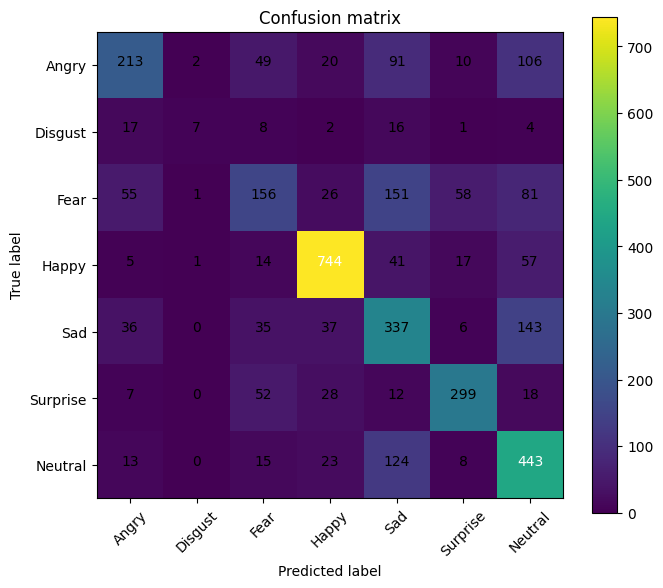

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools

# load best model (if needed)
# from tensorflow.keras.models import load_model
# model = load_model('best_fer_model.h5')

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print("Test accuracy:", test_acc)

# Predictions
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print(classification_report(y_true_labels, y_pred_labels, target_names=[
    "Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"
]))

# Confusion matrix plot
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(7)
plt.xticks(tick_marks, ["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"], rotation=45)
plt.yticks(tick_marks, ["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"])
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

model = load_model('best_fer_model.h5')
emotion_map = {0:"Angry",1:"Disgust",2:"Fear",3:"Happy",4:"Sad",5:"Surprise",6:"Neutral"}

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
    for (x,y,w,h) in faces:
        face = gray[y:y+h, x:x+w]
        face = cv2.resize(face, (48,48))
        face = face.astype('float32') / 255.0
        face = np.expand_dims(face, axis=0)
        face = np.expand_dims(face, -1)
        preds = model.predict(face)
        label = emotion_map[np.argmax(preds)]
        cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,0), 2)
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)
    cv2.imshow('FER', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━